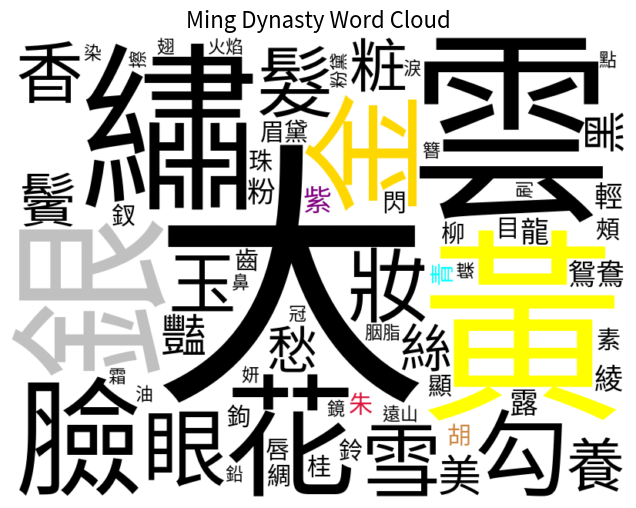

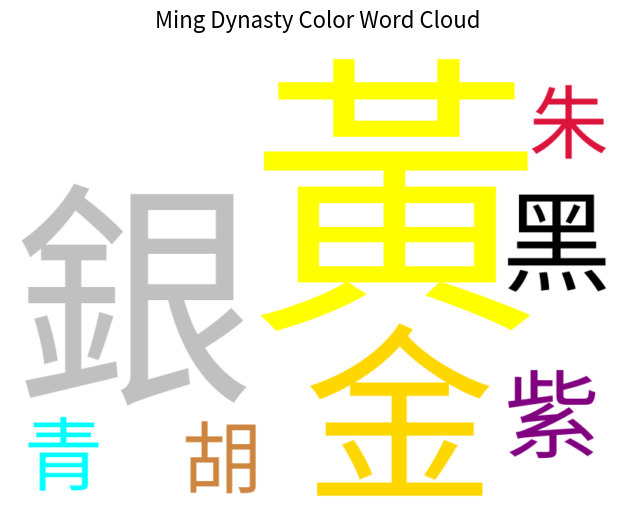

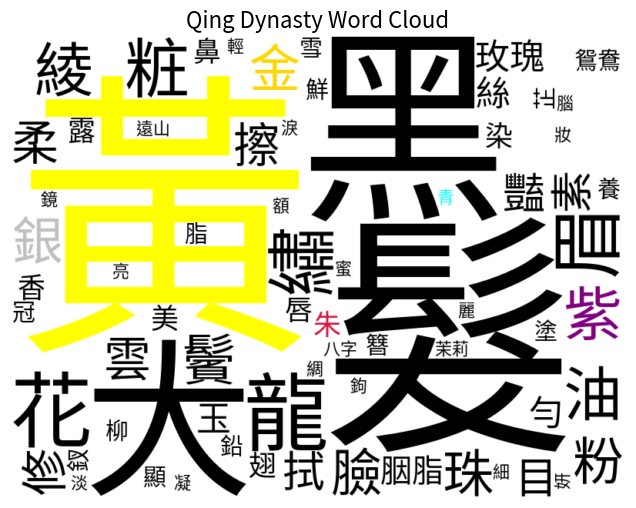

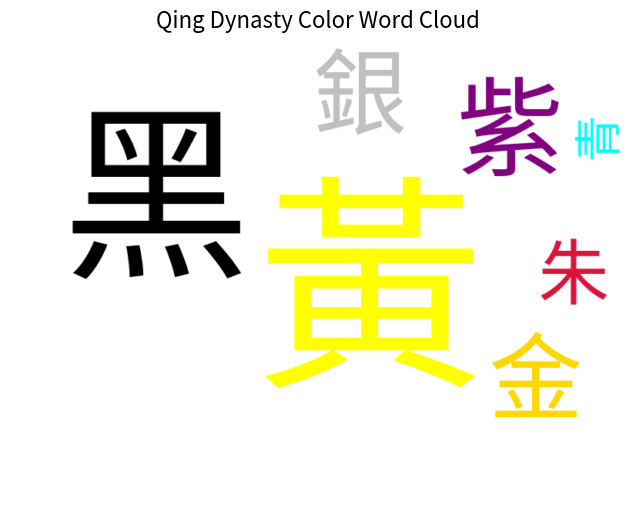

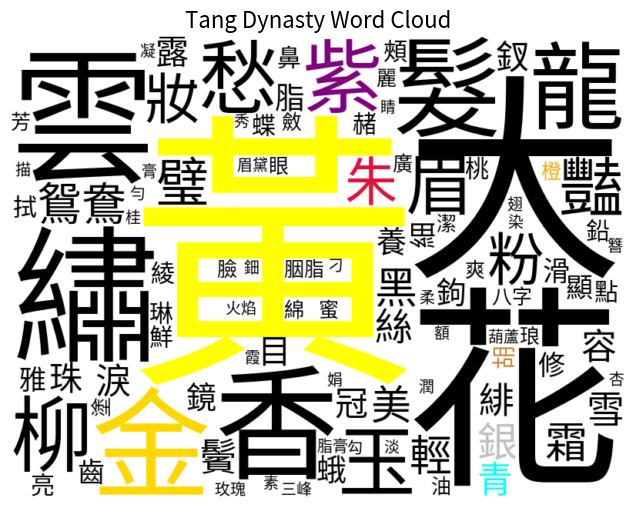

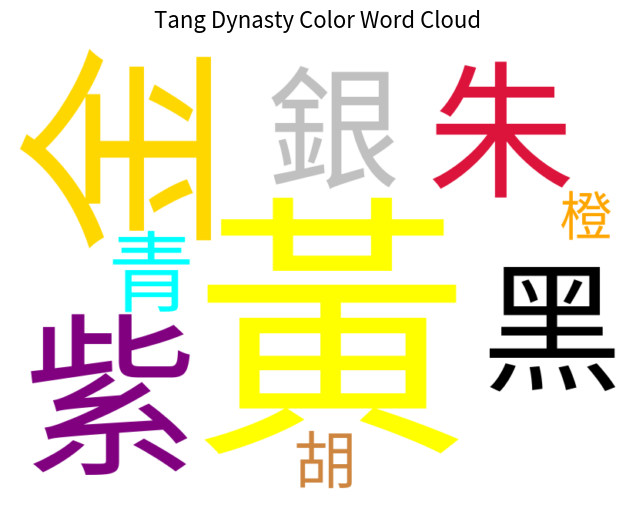

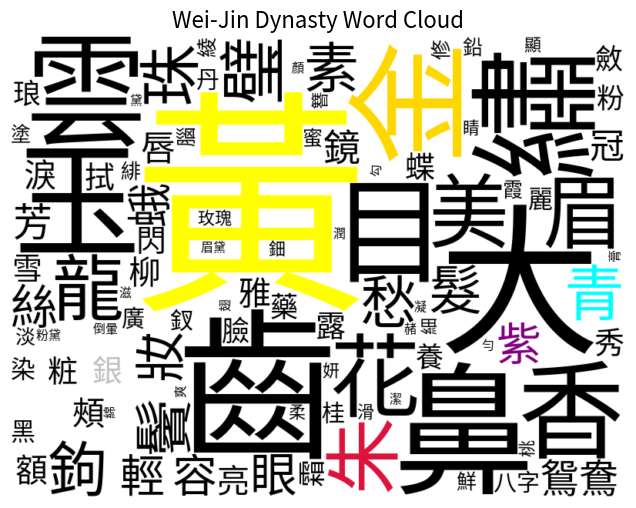

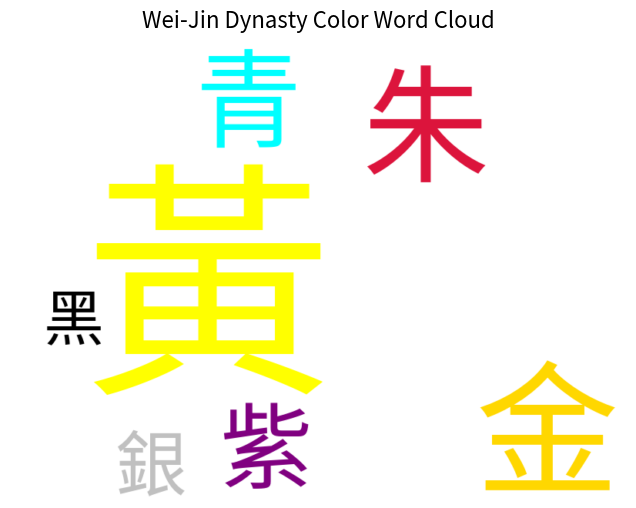

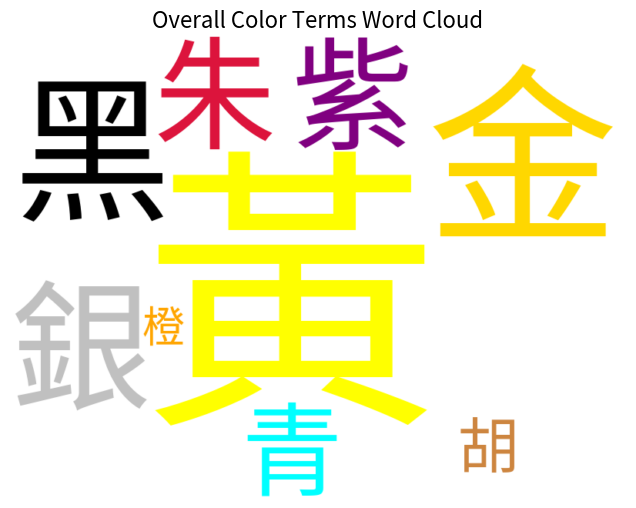

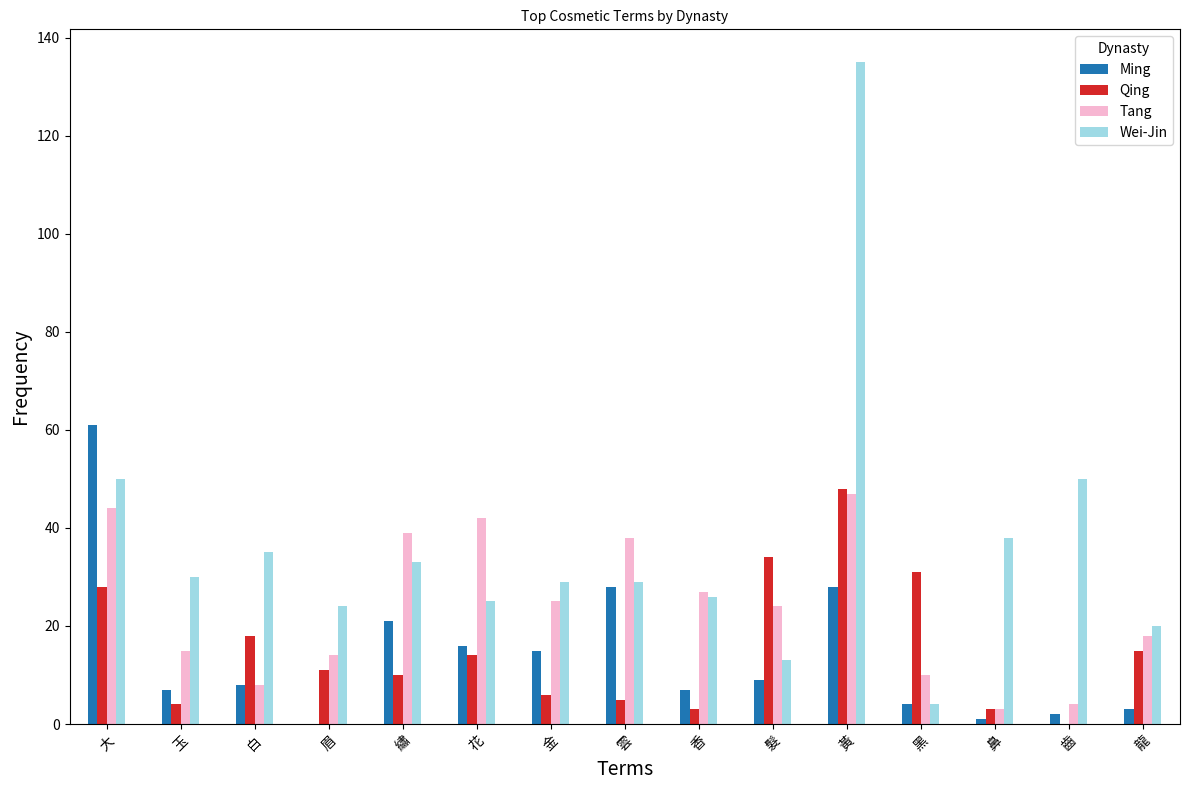

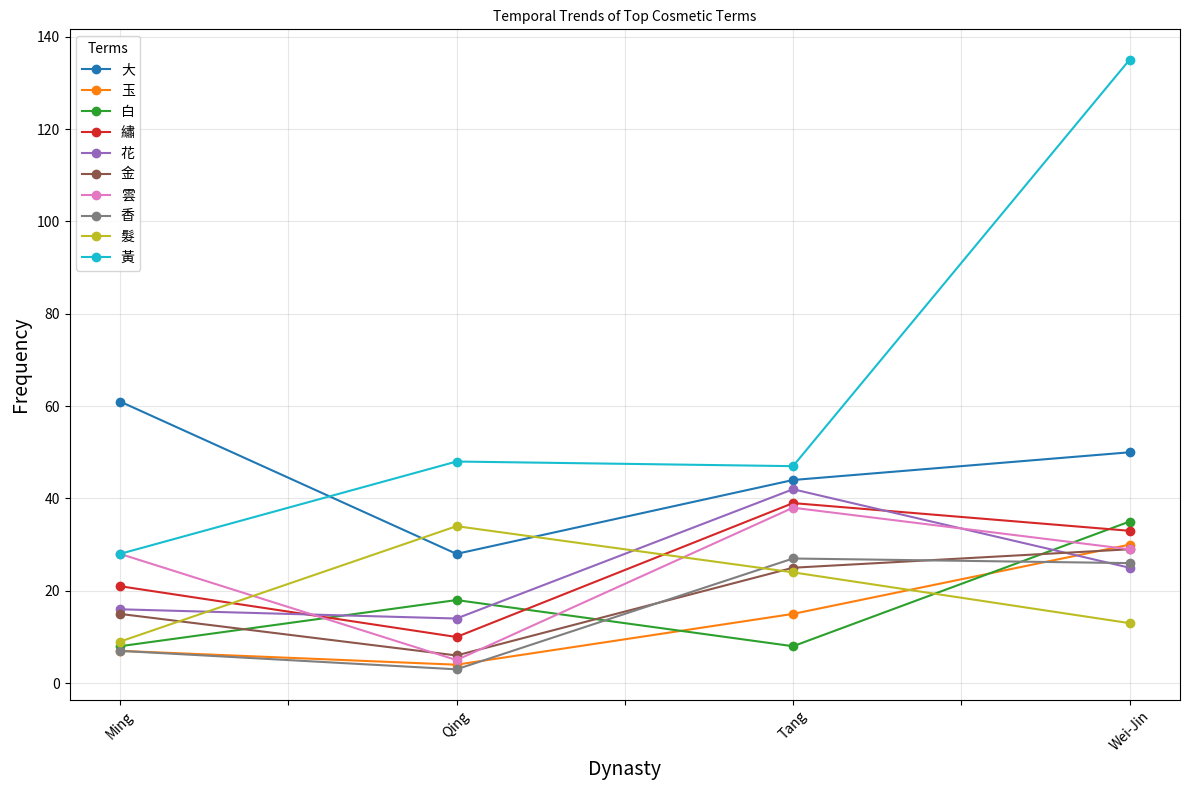

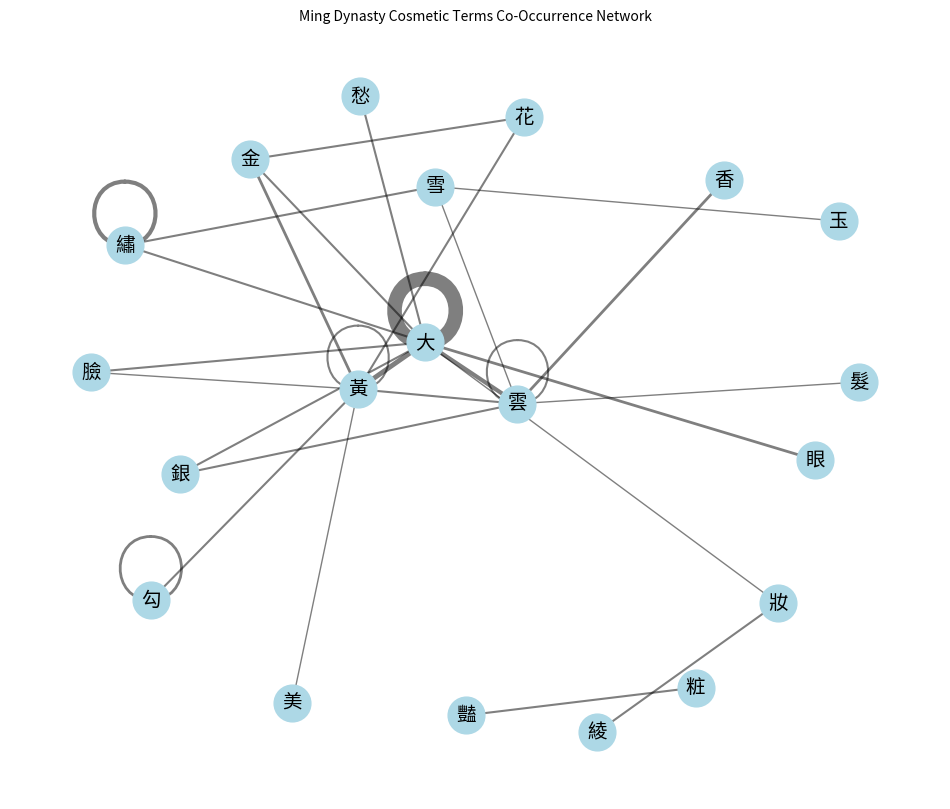

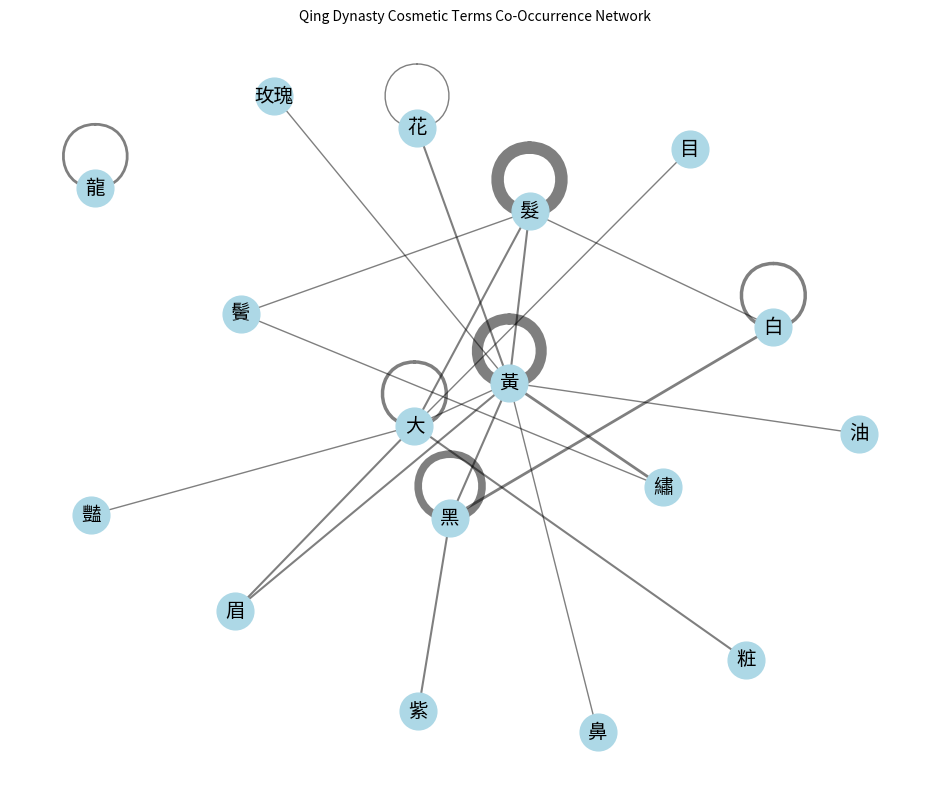

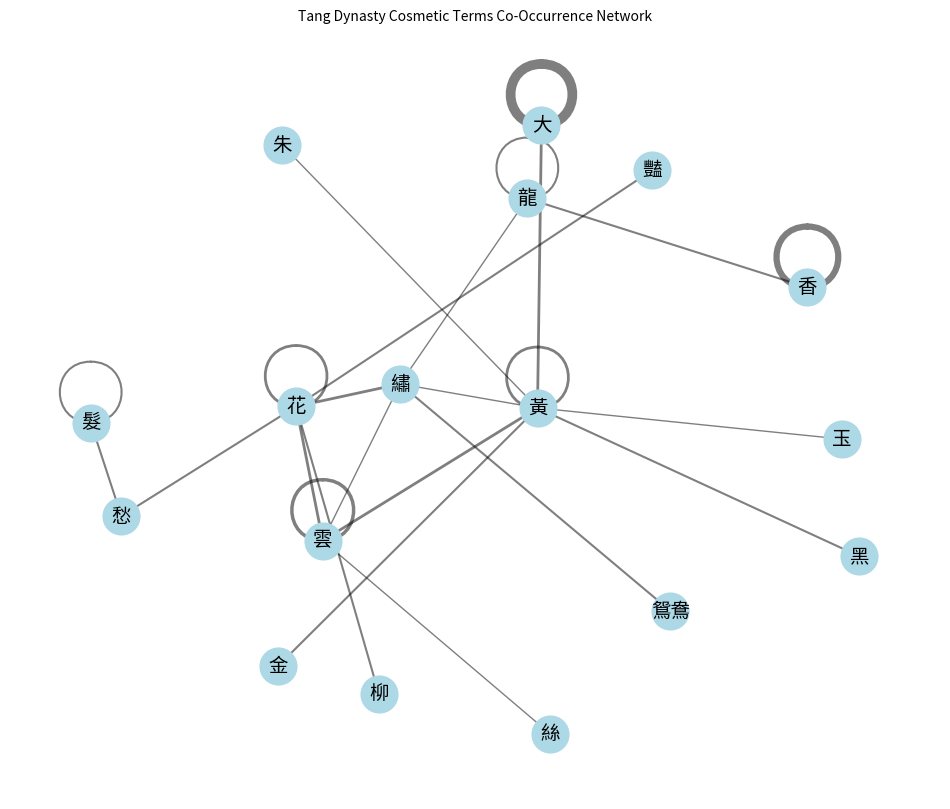

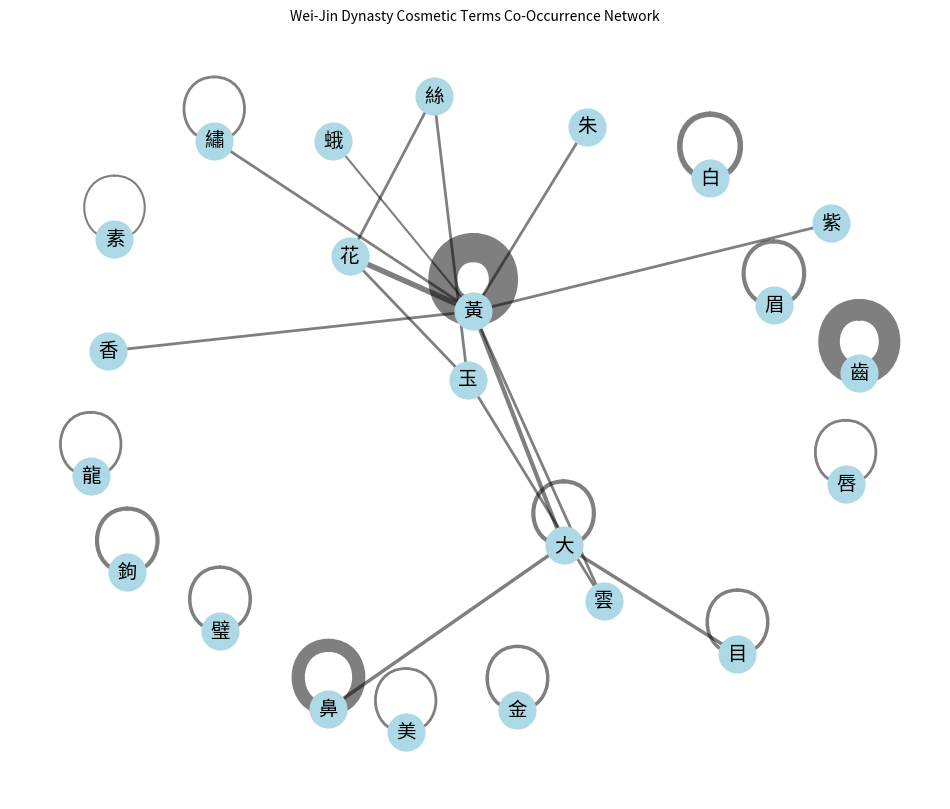

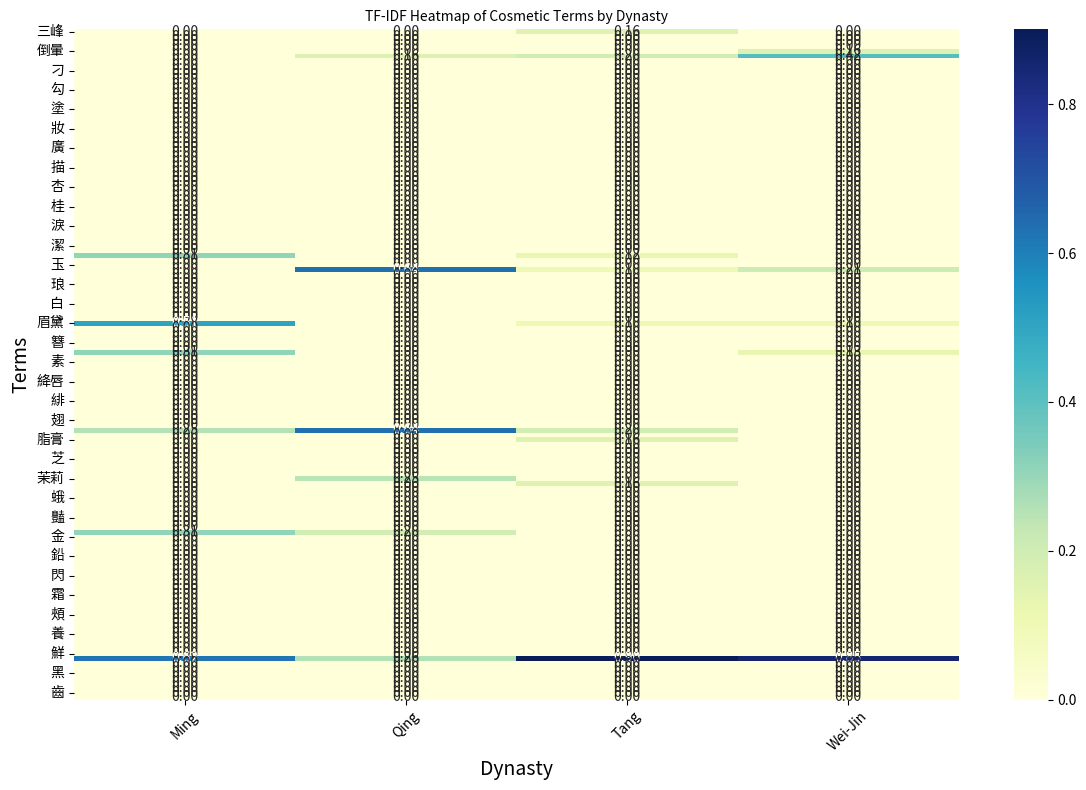

Topic 1: 0.009*"髮" + 0.009*"黃" + 0.009*"大" + 0.008*"龍" + 0.008*"黑" + 0.008*"花" + 0.008*"雲" + 0.008*"繡" + 0.008*"白" + 0.008*"金"

Topic 2: 0.109*"大" + 0.095*"黃" + 0.054*"髮" + 0.044*"黑" + 0.038*"雲" + 0.036*"繡" + 0.036*"花" + 0.033*"白" + 0.029*"銀" + 0.028*"臉"

Topic 3: 0.125*"黃" + 0.046*"大" + 0.046*"齒" + 0.035*"鼻" + 0.033*"白" + 0.031*"繡" + 0.028*"玉" + 0.027*"雲" + 0.027*"金" + 0.024*"目"

Topic 4: 0.061*"大" + 0.060*"花" + 0.056*"雲" + 0.056*"繡" + 0.051*"黃" + 0.038*"香" + 0.035*"金" + 0.033*"髮" + 0.025*"柳" + 0.024*"龍"

Topic 5: 0.009*"黃" + 0.009*"大" + 0.009*"黑" + 0.009*"髮" + 0.009*"白" + 0.008*"花" + 0.008*"繡" + 0.008*"雲" + 0.008*"金" + 0.008*"龍"

Chi-squared Statistic: 1137.3291732973767
Degrees of Freedom: 369
P-value: 3.174010311850672e-79
There is a significant difference in the usage of cosmetic terms between dynasties.


C:\Users\puipu\AppData\Local\Temp\ipykernel_10412\813014808.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Count', y='Word', palette='viridis')


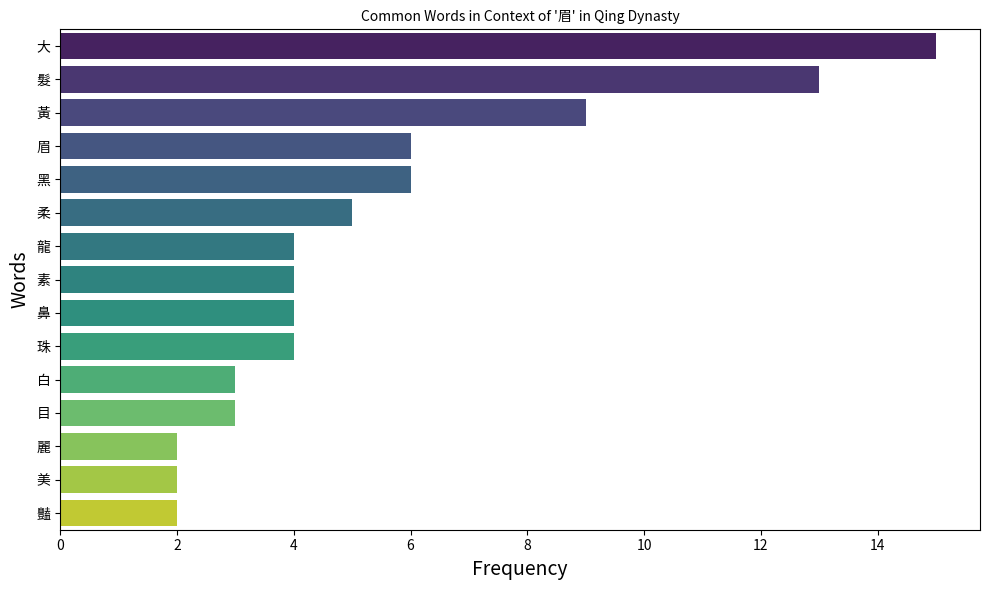

C:\Users\puipu\AppData\Local\Temp\ipykernel_10412\813014808.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Count', y='Word', palette='viridis')


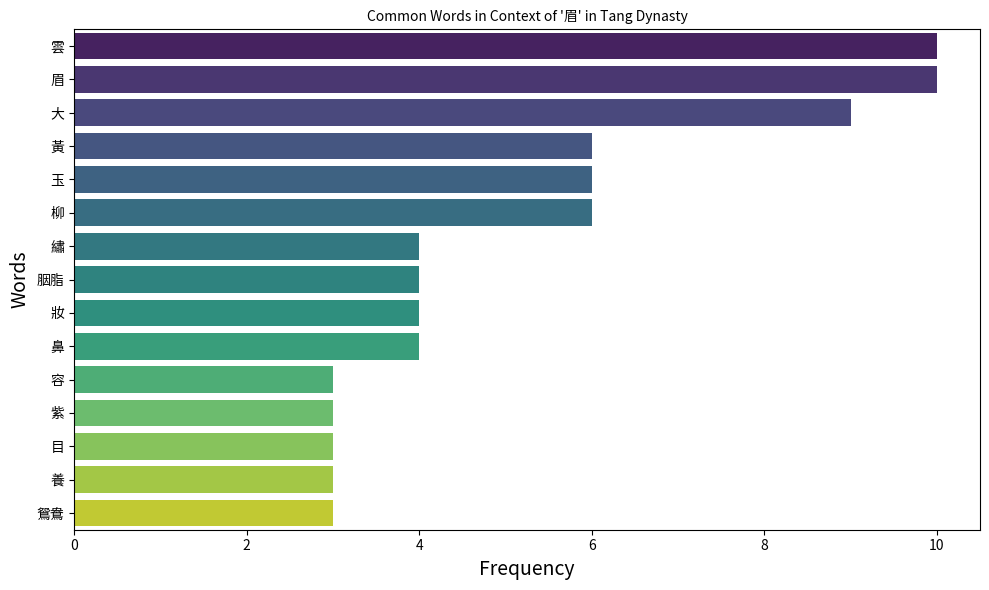

C:\Users\puipu\AppData\Local\Temp\ipykernel_10412\813014808.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Count', y='Word', palette='viridis')


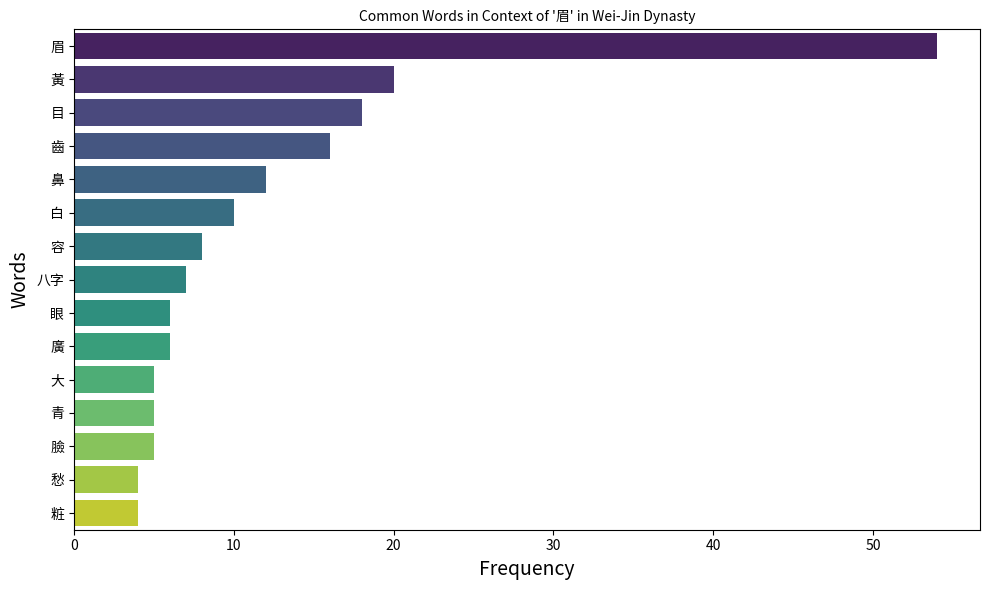

In [3]:
import os
import re
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import networkx as nx
from itertools import combinations
from gensim import corpora, models
from scipy.stats import chi2_contingency
from matplotlib import font_manager as fm

def load_texts_from_files(file_paths):
    texts = []
    dynasties = []
    for path, dynasty in file_paths.items():
        with open(path, 'r', encoding='utf-8') as file:
            text = file.read()
            texts.append(text)
            dynasties.append(dynasty)
    return texts, dynasties

def clean_text(text):
    punctuation_pattern = r'[^\w\s]'
    cleaned_text = re.sub(punctuation_pattern, '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

def tokenize_text(text):
    return jieba.lcut(text)

def match_cosmetic_terms(tokens, cosmetic_terms):
    return [token for token in tokens if token in cosmetic_terms]

def count_terms(matched_terms):
    return Counter(matched_terms)

def generate_word_cloud(matched_terms, font_path, title, color_map=None):
    if not matched_terms:
        return
    term_frequencies = Counter(matched_terms)

    def color_function(word, **kwargs):
        if color_map and word in color_map:
            return color_map[word]
        else:
            return 'black'

    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=600,
        background_color='white',
        color_func=color_function
    ).generate_from_frequencies(term_frequencies)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

def plot_term_frequencies_by_dynasty(data, top_k=10, font_prop=None):
    grouped = data.explode('matched_terms').groupby(['dynasty', 'matched_terms']).size().reset_index(name='count')
    top_terms = grouped.groupby('matched_terms')['count'].sum().nlargest(top_k).index
    filtered = grouped[grouped['matched_terms'].isin(top_terms)]
    pivot = filtered.pivot_table(index='matched_terms', columns='dynasty', values='count', aggfunc='sum').fillna(0)

    pivot.plot(kind='bar', figsize=(12, 8), colormap='tab20')
    plt.title('Top Cosmetic Terms by Dynasty', fontsize=16, fontproperties=font_prop)
    plt.xlabel('Terms', fontsize=14, fontproperties=font_prop)
    plt.ylabel('Frequency', fontsize=14, fontproperties=font_prop)
    plt.xticks(rotation=45, fontsize=12, fontproperties=font_prop)
    plt.legend(title='Dynasty', fontsize=12, prop=font_prop)
    plt.tight_layout()
    plt.show()

def plot_cooccurrence_network(dynasty_tokens, font_prop=None):
    for dynasty, tokens in dynasty_tokens.items():
        if not tokens:
            continue
        cooccurrence_pairs = []
        window_size = 2
        for i in range(len(tokens) - window_size + 1):
            window = tokens[i:i + window_size]
            pairs = combinations(window, 2)
            cooccurrence_pairs.extend(pairs)
        pair_counts = Counter(cooccurrence_pairs)
        top_pairs = pair_counts.most_common(30)
        if not top_pairs:
            continue
        G = nx.Graph()
        for (word1, word2), weight in top_pairs:
            G.add_edge(word1, word2, weight=weight)
        pos = nx.spring_layout(G, k=2, seed=42)
        plt.figure(figsize=(12, 10))
        weights = [G[u][v]['weight'] for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, width=[w * 0.5 for w in weights], alpha=0.5)
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
        font_name = font_prop.get_name()
        nx.draw_networkx_labels(G, pos, font_size=14, font_family=font_name)
        plt.title(f'{dynasty} Dynasty Cosmetic Terms Co-Occurrence Network', fontsize=16, fontproperties=font_prop)
        plt.axis('off')
        plt.show()

def tfidf_analysis(data, cosmetic_terms, font_prop=None):
    texts = [' '.join(tokens) for tokens in data['tokens']]
    vectorizer = TfidfVectorizer(vocabulary=cosmetic_terms)
    tfidf_matrix = vectorizer.fit_transform(texts)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=data['dynasty'])

    plt.figure(figsize=(12, 8))
    sns.heatmap(tfidf_df.T, cmap='YlGnBu', annot=True, fmt=".2f")
    plt.title('TF-IDF Heatmap of Cosmetic Terms by Dynasty', fontsize=16, fontproperties=font_prop)
    plt.xlabel('Dynasty', fontsize=14, fontproperties=font_prop)
    plt.ylabel('Terms', fontsize=14, fontproperties=font_prop)
    plt.xticks(rotation=45, fontsize=12, fontproperties=font_prop)
    plt.yticks(rotation=0, fontsize=12, fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

def plot_temporal_trends(data, top_k=10, font_prop=None):
    term_trends = data.explode('matched_terms').groupby(['dynasty', 'matched_terms']).size().reset_index(name='count')
    top_terms = term_trends.groupby('matched_terms')['count'].sum().nlargest(top_k).index
    filtered = term_trends[term_trends['matched_terms'].isin(top_terms)]
    pivot = filtered.pivot_table(index='dynasty', columns='matched_terms', values='count', aggfunc='sum').fillna(0)

    pivot.plot(figsize=(12, 8), marker='o')
    plt.title('Temporal Trends of Top Cosmetic Terms', fontsize=16, fontproperties=font_prop)
    plt.xlabel('Dynasty', fontsize=14, fontproperties=font_prop)
    plt.ylabel('Frequency', fontsize=14, fontproperties=font_prop)
    plt.xticks(rotation=45, fontsize=12, fontproperties=font_prop)
    plt.legend(title='Terms', fontsize=12, prop=font_prop)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def topic_modeling(data, num_topics=5):
    texts = data['tokens'].tolist()
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx+1}: {topic}\n")

def chi_square_test(data):
    contingency_table = data.explode('matched_terms').groupby(['dynasty', 'matched_terms']).size().unstack(fill_value=0)
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"Chi-squared Statistic: {chi2}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-value: {p}")
    if p < 0.05:
        print("There is a significant difference in the usage of cosmetic terms between dynasties.")
    else:
        print("No significant difference found in the usage of cosmetic terms between dynasties.")

def keyword_in_context(data, keyword="眉", window=5, font_prop=None):
    context_words_per_dynasty = {}

    for idx, row in data.iterrows():
        dynasty = row['dynasty']
        tokens = row['tokens']
        contexts = []
        for i, token in enumerate(tokens):
            if token == keyword:
                start = max(i - window, 0)
                end = min(i + window + 1, len(tokens))
                context = tokens[start:i] + tokens[i+1:end]
                contexts.extend(context)
        if dynasty not in context_words_per_dynasty:
            context_words_per_dynasty[dynasty] = contexts
        else:
            context_words_per_dynasty[dynasty].extend(contexts)

    stopwords = {'的', '了', '是', '在', '和', '有', '也', '就', '不', '人', '都', '他', '她', '地'}

    for dynasty, context_words in context_words_per_dynasty.items():
        if not context_words:
            continue
        context_words = [word for word in context_words if word not in stopwords]
        word_counts = Counter(context_words)
        most_common = word_counts.most_common(15)
        df = pd.DataFrame(most_common, columns=['Word', 'Count'])

        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='Count', y='Word', palette='viridis')
        plt.title(f"Common Words in Context of '{keyword}' in {dynasty} Dynasty", fontsize=16, fontproperties=font_prop)
        plt.xlabel('Frequency', fontsize=14, fontproperties=font_prop)
        plt.ylabel('Words', fontsize=14, fontproperties=font_prop)
        plt.xticks(fontsize=12, fontproperties=font_prop)
        plt.yticks(fontsize=12, fontproperties=font_prop)
        plt.tight_layout()
        plt.show()

def main():
    file_paths = {
        r'C:\Users\puipu\Documents\MScGAH\CHC5904\CHC Cosmetic\CHC5904 Ming.txt': 'Ming',
        r'C:\Users\puipu\Documents\MScGAH\CHC5904\CHC Cosmetic\CHC5904 Qing.txt': 'Qing',
        r'C:\Users\puipu\Documents\MScGAH\CHC5904\CHC Cosmetic\CHC5904 Tang.txt': 'Tang',
        r'C:\Users\puipu\Documents\MScGAH\CHC5904\CHC Cosmetic\CHC5904 Wei, Jin and North-South Dynasty.txt': 'Wei-Jin'
    }
    texts, dynasties = load_texts_from_files(file_paths)
    font_path = r'C:\Users\puipu\Documents\MScGAH\CHC5904\CHC Cosmetic\SourceHanSansHC-Regular.otf'

    fm.fontManager.addfont(font_path)
    font_prop = fm.FontProperties(fname=font_path)
    font_name = font_prop.get_name()
    plt.rcParams['font.family'] = font_name

    cosmetic_terms_raw = """
    妝 粉 脂 丹 素 黛 鉛 香 膏 眉 臉 白 红 紫 黑 額 鬢 髮 絲 綢 花 露 芳 茉莉 桂 玫瑰 芷 芝 蘇合 蜜 藥 油 杏 桃 龍 腦
    塗 擦 拭 勻 粧 修 顯 染 刷 勾 描 斂 輕 柔 滋 潤 亮 閃 簪 釵 鈿 鏡 奁 綾 繡 鈴 琳 琅 玉 珠 璧 琥 珀 鉤 冠 美 豔 絳唇 
    鮮 麗 秀 皙 滑 潔 細 妍 雅 淡 凝 顏 容 鬢 唇 頰 鼻 目 眼 睛 淚 齒 銀 養 爽 綿 金 胡 朱 橙 霞 緋 赭 青 黃
    霜 雪 脂膏 粉黛 眉黛 胭脂 蛾 雲 蝶 翅 峨 柳 葫蘆 鴛鴦 火焰 點 花 刁 螳螂 遠山 分梢 三峰 拂雲 垂珠 倒暈 八字 卻月 黛 娟 廣 大 愁   
    """
    cosmetic_terms = set(cosmetic_terms_raw.split())

    data = pd.DataFrame(columns=['text', 'dynasty', 'tokens', 'matched_terms'])
    all_matched_terms = []
    tokens_list = []
    dynasty_tokens = {}
    color_terms = ["白", "红", "紫", "黑", "銀", "金", "胡", "朱", "橙", "青", "黃"]
    color_map = {
        "红": "red", "紫": "purple", "黑": "black", "白": "white", "銀": "silver", "金": "gold",
        "胡": "peru", "朱": "crimson", "橙": "orange", "青": "cyan", "黃": "yellow"
    }

    for text, dynasty in zip(texts, dynasties):
        cleaned = clean_text(text)
        tokens = tokenize_text(cleaned)
        tokens_list.extend(tokens)
        cosmetic_tokens = match_cosmetic_terms(tokens, cosmetic_terms)
        if dynasty not in dynasty_tokens:
            dynasty_tokens[dynasty] = cosmetic_tokens
        else:
            dynasty_tokens[dynasty].extend(cosmetic_tokens)
        all_matched_terms.extend(cosmetic_tokens)
        new_row = pd.DataFrame([{
            'text': text,
            'dynasty': dynasty,
            'tokens': cosmetic_tokens,
            'matched_terms': cosmetic_tokens
        }])
        data = pd.concat([data, new_row], ignore_index=True)
        dynasty_color_map = {term: color_map[term] for term in cosmetic_tokens if term in color_terms}
        generate_word_cloud(cosmetic_tokens, font_path, f"{dynasty} Dynasty Word Cloud", color_map=dynasty_color_map)
        dynasty_color_terms = [term for term in cosmetic_tokens if term in color_terms]
        if dynasty_color_terms:
            generate_word_cloud(dynasty_color_terms, font_path, f"{dynasty} Dynasty Color Word Cloud", color_map=color_map)
    color_matched_terms = [term for term in all_matched_terms if term in color_terms]
    if color_matched_terms:
        overall_color_map = {term: color_map[term] for term in set(color_matched_terms)}
        generate_word_cloud(color_matched_terms, font_path, "Overall Color Terms Word Cloud", color_map=overall_color_map)

    plot_term_frequencies_by_dynasty(data, top_k=15, font_prop=font_prop)
    plot_temporal_trends(data, top_k=10, font_prop=font_prop)
    plot_cooccurrence_network(dynasty_tokens, font_prop=font_prop)
    tfidf_analysis(data, cosmetic_terms, font_prop=font_prop)
    topic_modeling(data, num_topics=5)
    chi_square_test(data)
    keyword_in_context(data, keyword="眉", window=5, font_prop=font_prop)

if __name__ == "__main__":
    main()